# U-net Task 1

## import libraries

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.python.keras.layers import concatenate, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

## Dowload images

In [2]:
!pip install wget
import wget
import os
url = "https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz"
wget.download(url, '.')
!tar -zxvf facades.tar.gz

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=4769d0d2cde1929680f9392131b4326c847928564ef51deedc1cf489ea458774
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facades/test/19.jpg
facades/test/2.jpg
facades/test/20.jpg
facades/test/21.jpg
facades/test/22.jpg
facades/test/23.jpg
facades/test/24.jpg
facades/test/25.jpg
facades/test/26.jpg
facades/test/50.jpg
facades/test/51.jpg
facades/test/52.jpg
facades/test/53.jpg
facades/test/54.jpg
facades/test/55.jp

input_train :  (400, 256, 256, 3)
output_train :  (400, 256, 256, 3)
input_val :  (100, 256, 256, 3)
output_val :  (100, 256, 256, 3)
input_test :  (106, 256, 256, 3)
output_test :  (106, 256, 256, 3)

Plot example from training set

item_id :  5



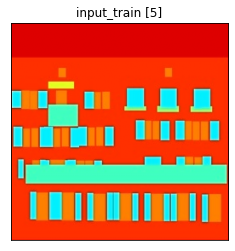

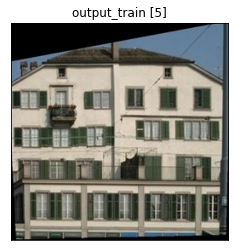

In [4]:
# import and normalize train, test, and validation images
files_train = glob.glob('facades/train/*')
pass_train = [i for i in files_train]
input_train = np.array([cv2.imread(i, cv2.IMREAD_COLOR)[:,256:,:] for i in pass_train])
output_train = np.array([cv2.cvtColor(cv2.imread(i, cv2.IMREAD_COLOR)[:,:256,:], cv2.COLOR_BGR2RGB) for i in pass_train])
input_train = input_train/255.0
output_train = output_train/255.0

files_test = glob.glob('facades/test/*')
pass_test = [i for i in files_test]
input_test = np.array([cv2.cvtColor(cv2.imread(i, cv2.IMREAD_COLOR)[:,256:,:], cv2.COLOR_BGR2RGB) for i in pass_test])
output_test = np.array([cv2.cvtColor(cv2.imread(i, cv2.IMREAD_COLOR)[:,:256,:], cv2.COLOR_BGR2RGB) for i in pass_test])
input_test = input_test/255.0 
output_test = output_test/255.0

files_val = glob.glob('facades/val/*')
pass_val = [i for i in files_val]
input_val = np.array([cv2.cvtColor(cv2.imread(i, cv2.IMREAD_COLOR)[:,256:,:], cv2.COLOR_BGR2RGB) for i in pass_val])
output_val = np.array([cv2.cvtColor(cv2.imread(i, cv2.IMREAD_COLOR)[:,:256,:], cv2.COLOR_BGR2RGB) for i in pass_val])
input_val = input_val/255.0
output_val = output_val/255.0

print('input_train : ', input_train.shape)
print('output_train : ', output_train.shape)
print('input_val : ', input_val.shape)
print('output_val : ', output_val.shape)
print('input_test : ', input_test.shape)
print('output_test : ', output_test.shape)
print()
print('Plot example from training set')
print()
item_id = 5
print('item_id : ', item_id)
print()

# show sample training input and output
plt.imshow(input_train[item_id])
plt.title('input_train [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(output_train[item_id])
plt.title('output_train [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

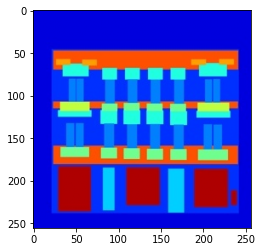

In [6]:
plt.imshow(input_test[0])

## Define network

In [0]:
def unet(
    input_train = input_train, 
    output_train = output_train,
    input_val = input_val,
    output_val = output_val,
    optimizer_type = Adam(lr=2e-4),
    loss = 'mean_squared_error',
    dropout_ratio = 0.0,
    max_epochs = 50,
    batch_size = 32,
    batch_shuffle = True,
    remove_skipconnection = False):

    # define input shape
    input_shape = (256, 256, 3)
    inputs = Input(shape=input_shape)

    # encoder section

    down0 = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = LeakyReLU()(down0)

    down1 = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(down0)
    down1 = BatchNormalization()(down1)
    down1 = LeakyReLU()(down1)

    down2 = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU()(down2)

    down3 = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU()(down3)

    down4 = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(down3)
    down4 = BatchNormalization()(down4)
    down4 = LeakyReLU()(down4)

    down5 = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(down4)
    down5 = BatchNormalization()(down5)
    down5 = LeakyReLU()(down5)

    down6 = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(down5)
    down6 = BatchNormalization()(down6)
    down6 = LeakyReLU()(down6)

    # center section

    center = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(down6)
    center = BatchNormalization()(center)
    center = LeakyReLU()(center)
        
    # decoder section with skip connections to the encoder section

    up6 = UpSampling2D(size=(2, 2))(center)
    up6 = concatenate([down6, up6], axis=3)
    up6 = Conv2D(512, (4, 4), padding='same')(up6)
    up6 = BatchNormalization()(up6)
    up6 = LeakyReLU()(up6)

    up5 = UpSampling2D(size=(2, 2))(up6)
    if not(remove_skipconnection):
        up5 = concatenate([down5, up5], axis=3)
    up5 = Conv2D(512, (4, 4), padding='same')(up5)
    up5 = BatchNormalization()(up5)
    up5 = LeakyReLU()(up5)

    up4 = UpSampling2D(size=(2, 2))(up5)
    if not(remove_skipconnection):
        up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (4, 4), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = LeakyReLU()(up4)

    up3 = UpSampling2D(size=(2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(512, (4, 4), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = LeakyReLU()(up3)

    up2 = UpSampling2D(size=(2, 2))(up3)
    if not(remove_skipconnection):
        up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(256, (4, 4), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = LeakyReLU()(up2)

    up1 = UpSampling2D(size=(2, 2))(up2)
    if not(remove_skipconnection):
        up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(128, (4, 4), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = LeakyReLU()(up1)

    up0 = UpSampling2D(size=(2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(64, (4, 4), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = LeakyReLU()(up0)

    outputs = UpSampling2D(size=(2, 2))(up0)
    outputs = Conv2D(3, (4, 4), padding='same')(outputs)
    outputs = Activation('tanh')(outputs)

    # compile the network
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer_type, loss=loss)
    # Display a summary of the compiled neural network
    print(model.summary())  
    print()

    print('* Training the compiled network *')
    print()
    history = model.fit(input_train, output_train, \
                        batch_size=batch_size, \
                        epochs=max_epochs, \
                        validation_data=(input_val, output_val), \
                        shuffle=batch_shuffle)
    print()
    print('Training completed')
    print()

    return model, history

In [0]:
# function to show reconstructed images
def show_result(model, input_test = input_test, output_test = output_test, idx = [1,2,3,4]):
    model_out = model.predict(input_test[idx])
    for i in range(4):
        fig = plt.figure(figsize=(12, 4))
        j = idx[i]
        plt.subplot(1,3,1);plt.imshow(input_test[j]);plt.title('test_input')
        plt.subplot(1,3,2);plt.imshow(output_test[j]);plt.title('true_image')
        plt.subplot(1,3,3);plt.imshow(model_out[i]);plt.title('Reconstructed image')
        plt.show()

In [0]:
# train unet without with skip connections shown in Fig1.a
model, history = unet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


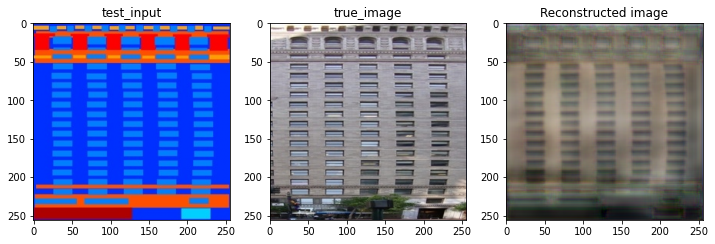

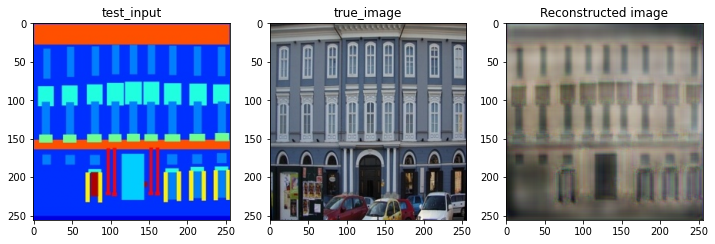

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


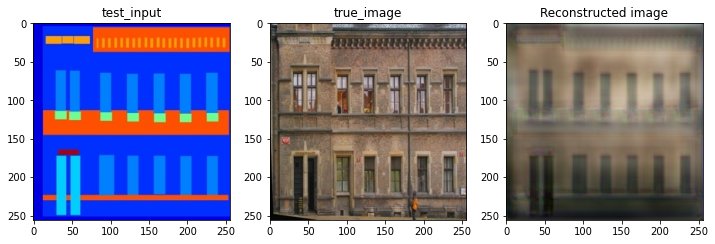

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


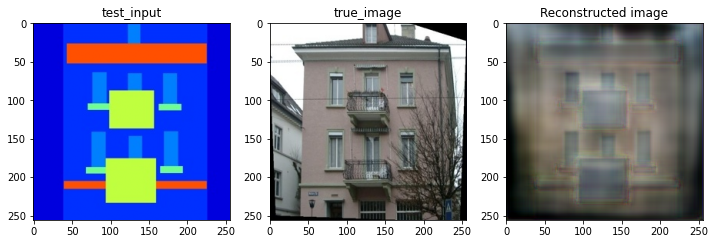

In [0]:
# show reconstructed images along the ground truth images
show_result(model, idx = [15,25,45,65])

## Task 2

In [0]:
# train unet without with skip connections shown in Fig1.b
model2, history2 = unet(remove_skipconnection = True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 128, 128, 64) 256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 128, 128, 64) 0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [0]:
def show_result2(model, model2, input_test = input_test, output_test = output_test,idx=[11,22,33,44]):
    model_out = model.predict(input_test[idx])
    model_out2 = model2.predict(input_test[idx])
    for i in range(4):
        fig = plt.figure(figsize=(12, 4))
        j = idx[i]
        plt.subplot(1,4,1);plt.imshow(input_test[j]);plt.title('test_input')
        plt.subplot(1,4,2);plt.imshow(output_test[j]);plt.title('true_image')
        plt.subplot(1,4,3);plt.imshow(model_out[i]);plt.title('task1')
        plt.subplot(1,4,4);plt.imshow(model_out2[i]);plt.title('task2')
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


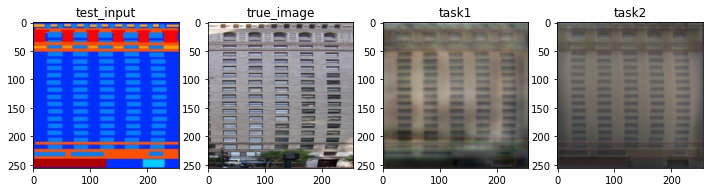

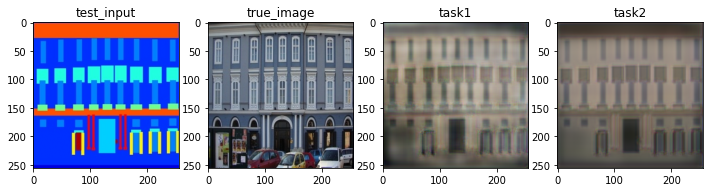

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


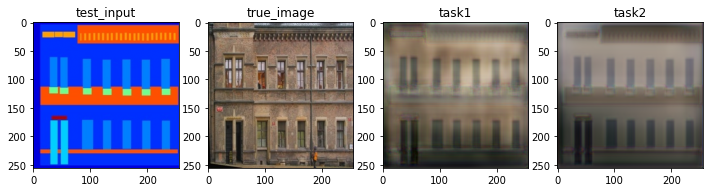

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


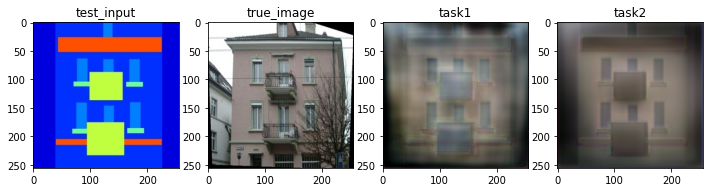

In [0]:
# compare reconstructed images generated from task1 and task2
show_result2(model, model2,idx=[15,25,45,65])

## Removing skipping connections improve reconstructed images.